In [2]:
"""
The evaluation API requires that you set up a server which will respond to inference requests.
We have already defined the server; you just need write the predict function.
When we evaluate your submission on the hidden test set the client defined in `default_gateway` will run in a different container
with direct access to the hidden test set and hand off the data timestep by timestep.

Your code will always have access to the published copies of the copmetition files.
"""

import os

import pandas as pd
import polars as pl

import kaggle_evaluation.default_inference_server

In [12]:
import os
import pandas as pd
import polars as pl
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import kaggle_evaluation.default_inference_server

# Global variable
model = None
scaler = None

# The selected features and their ranking in importance
selected_features = ['M4', 'V13', 'S5', 'S2', 'V7', 'M2', 'M17', 'M12', 'M8', 'S6']
feature_importance = {
    'M4': 0.064640, 'V13': 0.060401, 'S5': 0.038784, 'S2': 0.036403, 
    'V7': 0.031324, 'M2': 0.027129, 'M17': 0.023138, 'M12': 0.022796, 
    'M8': 0.020233, 'S6': 0.019638
}

def predict(test: pl.DataFrame) -> float:
    global model, scaler
    
    try:
        # Convert to pandas
        test_data = test.to_pandas()
        
        # Train the model for the first call
        if model is None:
            print("The first call, training the MLP model...")
            train_model()
        
        # Prepare features (only use existing features)
        available_features = [f for f in selected_features if f in test_data.columns]
        X_test = test_data[available_features].fillna(0)
        X_test_scaled = scaler.transform(X_test)
        
        # Predicted earnings
        predicted_return = model.predict(X_test_scaled)[0]
        
        # Convert to weights (weighted based on importance)
        base_weight = 1.0
        
        # Adjust the weights based on the predicted returns and the importance of features
        if predicted_return > 0.01:
            adjustment = 0.6
        elif predicted_return > 0.005:
            adjustment = 0.3
        elif predicted_return > 0:
            adjustment = 0.1
        elif predicted_return > -0.005:
            adjustment = -0.1
        elif predicted_return > -0.01:
            adjustment = -0.3
        else:
            adjustment = -0.6
        
        weight = base_weight + adjustment
        weight = max(0.0, min(2.0, weight))
        
        print(f"Predicted earnings: {predicted_return:.4f} -> Weight: {weight:.2f}")
        return float(weight)
        
    except Exception as e:
        print(f"Prediction error: {e}, Use the default weight 1.0")
        return 1.0

def train_model():
    global model, scaler
    
    # Loading data...
    train_df = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
    
    print("The features used and their significance:")
    for feature in selected_features:
        if feature in feature_importance:
            print(f"  {feature}: {feature_importance[feature]:.6f}")
    
    # Prepare the training data (using only existing features)
    available_features = [f for f in selected_features if f in train_df.columns]
    X_train = train_df[available_features].fillna(0)
    y_train = train_df['forward_returns']
    
    # Data standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # create MLP model
    model = MLPRegressor(
        hidden_layer_sizes=(64, 32),  # Two-layer network
        activation='relu',
        solver='adam',
        alpha=0.001,  # L2 regularization
        learning_rate_init=0.001,
        max_iter=100,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42,
        verbose=True  # Display the training process
    )
    
    # Train the model
    print("Start training")
    model.fit(X_train_scaled, y_train)
    
    # Display the training score
    train_score = model.score(X_train_scaled, y_train)
    print(f"Training set R² score: {train_score:.4f}")

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V4,V5,V6,V7,V8,V9,is_scored,lagged_forward_returns,lagged_risk_free_rate,lagged_market_forward_excess_returns
0,8980,0,0,0,0,1,0,0,1,0,...,0.828042,0.999172,0.759921,-0.803127,0.170966,-0.751909,True,0.003541,0.000161,0.003068
1,8981,0,0,0,0,1,0,0,1,0,...,0.831349,1.120336,0.556217,-0.686192,0.141865,-0.660326,True,-0.005964,0.000162,-0.006437
2,8982,0,0,0,0,1,0,0,0,1,...,0.832672,1.088992,0.665344,-0.459367,0.199405,-0.510979,True,-0.007410,0.000160,-0.007882
3,8983,0,0,0,0,1,0,0,0,1,...,0.835979,1.040988,0.594577,-0.561643,0.161706,-0.575997,True,0.005420,0.000160,0.004949
4,8984,0,0,0,0,0,0,1,0,1,...,0.839947,0.944593,0.715608,-0.692649,0.124669,-0.654045,True,0.008357,0.000159,0.007887


✅ 数据加载成功!
🔍 ========== 数据综合评估报告 ==========

📊 1. 基础数据信息
训练集形状: (9021, 98)
测试集形状: (10, 99)
训练集日期范围: 0 到 9020
测试集日期范围: 8980 到 8989

🎯 2. 目标变量分析

forward_returns:
  非空数量: 9021 / 9021
  均值: 0.000471
  标准差: 0.010541
  最小值: -0.039754
  最大值: 0.040661
  Sharpe比率(年化): 0.7100

risk_free_rate:
  非空数量: 9021 / 9021
  均值: 0.000107
  标准差: 0.000088
  最小值: -0.000004
  最大值: 0.000317
  Sharpe比率(年化): 19.3304

market_forward_excess_returns:
  非空数量: 9021 / 9021
  均值: 0.000053
  标准差: 0.010558
  最小值: -0.040582
  最大值: 0.040551
  Sharpe比率(年化): 0.0800

📈 3. 特征分组统计
市场技术(M*):
  特征数量: 18
  平均NaN比例: 25.41%
  平均值: 0.0499
  平均标准差: 0.8891
宏观经济(E*):
  特征数量: 20
  平均NaN比例: 15.23%
  平均值: 0.2714
  平均标准差: 0.7528
利率(I*):
  特征数量: 9
  平均NaN比例: 11.15%
  平均值: 0.3879
  平均标准差: 0.7000
价格估值(P*):
  特征数量: 13
  平均NaN比例: 12.70%
  平均值: 0.5089
  平均标准差: 0.7747
波动率(V*):
  特征数量: 13
  平均NaN比例: 19.76%
  平均值: 0.2815
  平均标准差: 0.6822
情绪(S*):
  特征数量: 12
  平均NaN比例: 20.17%
  平均值: 0.2915
  平均标准差: 0.7112
虚拟变量(D*):
  特征数量: 9
  平均NaN比例: 0.00%
  平均值: 0.10

C:\Users\jingyuan\AppData\Local\Temp\ipykernel_38280\3723867646.py:73: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_by_year = train_df.groupby('year_group').apply(lambda x: x.isna().any(axis=1).mean())


与forward_returns相关性最高的特征:
  D1: 0.0340
  D2: 0.0340
  E11: -0.0309
  E12: -0.0296
  D8: 0.0249
  E19: 0.0248
  D4: 0.0170
  D6: 0.0167
  D5: 0.0167
  D7: 0.0105

🔍 6. 测试集特殊列分析
is_scored: 9/10 行计分
lagged_forward_returns: 均值=0.001702, 标准差=0.005482
lagged_risk_free_rate: 均值=0.000158, 标准差=0.000002
lagged_market_forward_excess_returns: 均值=0.001232, 标准差=0.005483

💡 7. 数据质量建议
目标变量分布:
  偏度: -0.1782 (近似对称)
  峰度: 2.1979 (尖峰)
  异常值比例: 6.65%

🔧 8. 特征工程建议
建议进行相关性分析检查多重共线性

🎯 基于评估的策略建议
市场特征:
  • 日均收益: 0.0471%
  • 日波动率: 1.0541%
  • 年化夏普: 0.71

💡 策略建议: 考虑均值回归策略
✅ 风险提示: 市场波动正常


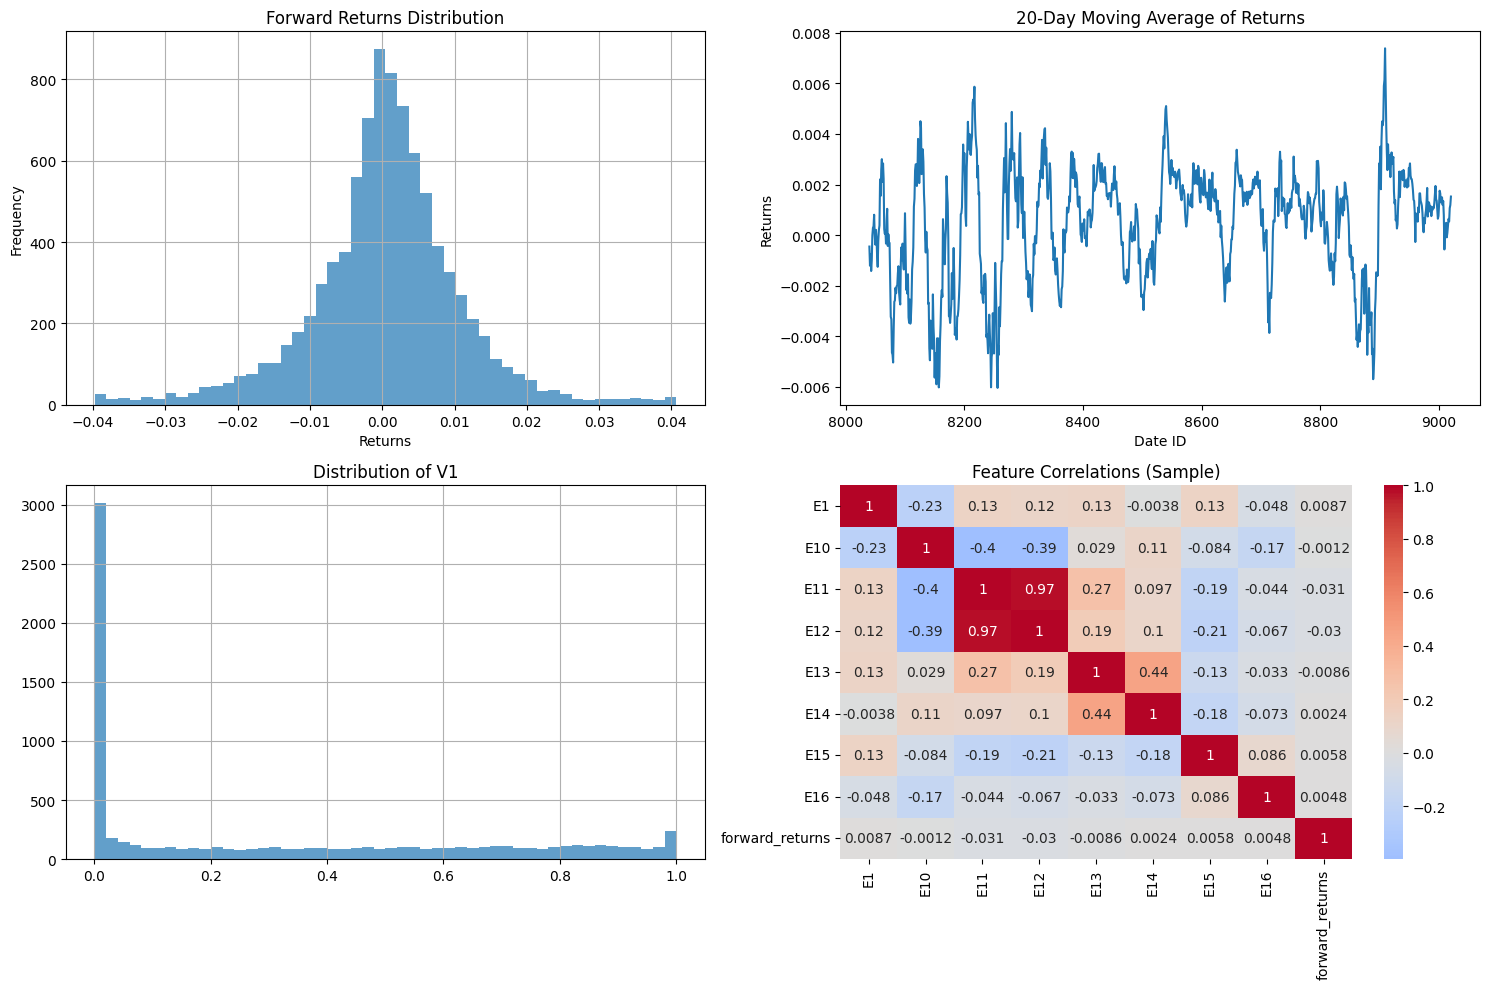

In [9]:
# When your notebook is run on the hidden test set, inference_server.serve must be called within 15 minutes of the notebook starting
# or the gateway will throw an error. If you need more than 15 minutes to load your model you can do so during the very
# first `predict` call, which does not have the usual 1 minute response deadline.
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(('/kaggle/input/hull-tactical-market-prediction/',))